# Chapter 8: Feature Importance

This notebook demonstrates feature importance techniques from **Advances in Financial Machine Learning** (AFML) Chapter 8.

## Marcos' First Law of Backtesting

> **"Backtesting is not a research tool. Feature importance is."**
> 
> — Marcos López de Prado

## Why Feature Importance Matters

One of the most pervasive mistakes in financial research is:
1. Take some data
2. Run it through an ML algorithm
3. Backtest the predictions
4. **Repeat until a nice-looking backtest shows up**

This approach leads to **false discoveries**. At a 5% significance level, it only takes ~20 iterations to find a spurious strategy!

**Feature importance is the antidote.** Understanding what features contribute to predictions helps us:
- Open the "black box" of ML models
- Identify truly predictive signals
- Detect overfitting before backtesting
- Build more robust strategies

## Table of Contents

1. [Setup and Synthetic Data](#1.-Setup-and-Synthetic-Data)
2. [Mean Decrease Impurity (MDI)](#2.-Mean-Decrease-Impurity-(MDI))
3. [Mean Decrease Accuracy (MDA)](#3.-Mean-Decrease-Accuracy-(MDA))
4. [Single Feature Importance (SFI)](#4.-Single-Feature-Importance-(SFI))
5. [Substitution Effects](#5.-Substitution-Effects)
6. [Orthogonal Features (PCA)](#6.-Orthogonal-Features-(PCA))
7. [Comparing Methods](#7.-Comparing-Methods)
8. [Best Practices](#8.-Best-Practices)

---

In [1]:
# Add project root to path
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# AFML feature importance module
from afml.feature_importance import (
    # MDI
    compute_mdi_importance,
    get_mdi_feature_ranking,
    # MDA
    compute_mda_importance,
    compute_mda_importance_simple,
    # SFI
    compute_sfi_importance,
    # Orthogonal features
    compute_orthogonal_features,
    compute_weighted_kendall_tau,
    compute_importance_pca_correlation,
    # Synthetic data
    generate_synthetic_dataset,
    generate_financial_synthetic_data,
    get_feature_types,
    analyze_importance_by_type,
    compute_importance_accuracy,
    # Plotting
    plot_feature_importance,
    plot_importance_comparison,
    plot_importance_by_type,
)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Random seed
np.random.seed(42)

print("Setup complete!")

Setup complete!


## 1. Setup and Synthetic Data

### Why Synthetic Data?

To evaluate feature importance methods, we need data where we **know the ground truth**. Synthetic data has three types of features:

| Type | Description | Should Be Important? |
|------|-------------|---------------------|
| **Informative (I)** | Features used to generate labels | Yes |
| **Redundant (R)** | Linear combinations of informative features | Yes (contain same info) |
| **Noise (N)** | Random features with no relation to labels | No |

A good feature importance method should:
- Rank I and R features higher than N features
- Handle redundant features appropriately

In [2]:
# Generate synthetic dataset
X, metadata = generate_synthetic_dataset(
    n_samples=10000,
    n_features=40,
    n_informative=10,
    n_redundant=10,
    random_state=42,
)
y = metadata['label'].values

print("Synthetic Dataset")
print("="*50)
print(f"Samples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")
print(f"  - Informative (I_*): 10")
print(f"  - Redundant (R_*): 10")
print(f"  - Noise (N_*): 20")
print(f"\nLabel distribution: {np.bincount(y)}")
print(f"\nFeature names (first 10): {X.columns.tolist()[:10]}")

Synthetic Dataset
Samples: 10000
Features: 40
  - Informative (I_*): 10
  - Redundant (R_*): 10
  - Noise (N_*): 20

Label distribution: [5003 4997]

Feature names (first 10): ['I_0', 'I_1', 'I_2', 'I_3', 'I_4', 'I_5', 'I_6', 'I_7', 'I_8', 'I_9']


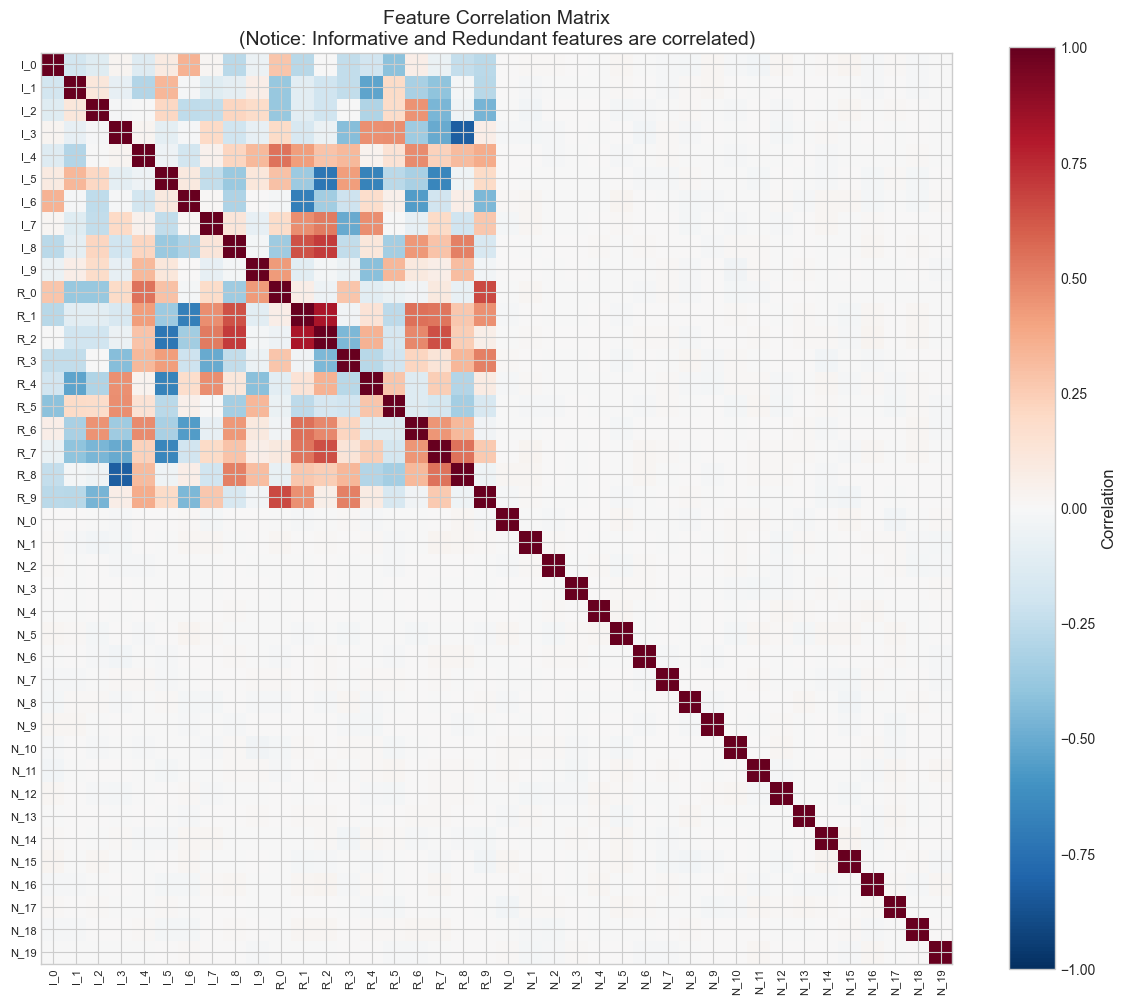

Key observation: Redundant features are correlated with Informative features.
This will cause 'substitution effects' in feature importance.


In [3]:
# Visualize correlation structure
fig, ax = plt.subplots(figsize=(12, 10))

corr = X.corr()
im = ax.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation', fontsize=12)

# Labels
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticklabels(corr.columns, fontsize=8)

ax.set_title('Feature Correlation Matrix\n(Notice: Informative and Redundant features are correlated)', fontsize=14)

plt.tight_layout()
plt.show()

print("Key observation: Redundant features are correlated with Informative features.")
print("This will cause 'substitution effects' in feature importance.")

## 2. Mean Decrease Impurity (MDI)

### How MDI Works

MDI is a **fast, in-sample** method specific to tree-based classifiers:

1. At each node of each decision tree, a feature is selected to split the data
2. The split decreases impurity (Gini or entropy)
3. For each tree, we track how much each feature contributed to impurity reduction
4. Average across all trees in the forest

### Key Considerations

| Issue | Solution |
|-------|----------|
| **Masking effects** | Set `max_features=1` so every feature gets a chance |
| **Zero importances** | Replace with NaN (0 means feature wasn't selected, not unimportant) |
| **In-sample only** | Every feature gets some importance, even noise |
| **Substitution effects** | Correlated features share importance |

In [4]:
# Train Random Forest with max_features=1 (critical for MDI!)
clf_mdi = RandomForestClassifier(
    n_estimators=1000,
    max_features=1,  # Critical: prevents masking effects
    max_depth=None,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    oob_score=True,
)
clf_mdi.fit(X.values, y)

print(f"Random Forest trained with {clf_mdi.n_estimators} trees")
print(f"OOB Score: {clf_mdi.oob_score_:.4f}")

Random Forest trained with 1000 trees
OOB Score: 0.9017


In [5]:
# Compute MDI importance
mdi_importance = compute_mdi_importance(clf_mdi, X.columns.tolist())

print("MDI Feature Importance (Top 15)")
print("="*50)
print(mdi_importance.sort_values('mean', ascending=False).head(15))

MDI Feature Importance (Top 15)
         mean       std
R_8  0.078125  0.001999
I_3  0.065215  0.001642
I_7  0.045236  0.001030
R_0  0.044268  0.000836
R_4  0.042100  0.000835
I_0  0.036943  0.000598
I_9  0.035550  0.000591
R_9  0.034704  0.000571
I_1  0.033691  0.000544
I_2  0.029348  0.000490
I_8  0.029214  0.000433
R_7  0.028897  0.000382
R_3  0.026742  0.000365
R_1  0.025726  0.000326
I_5  0.025510  0.000280


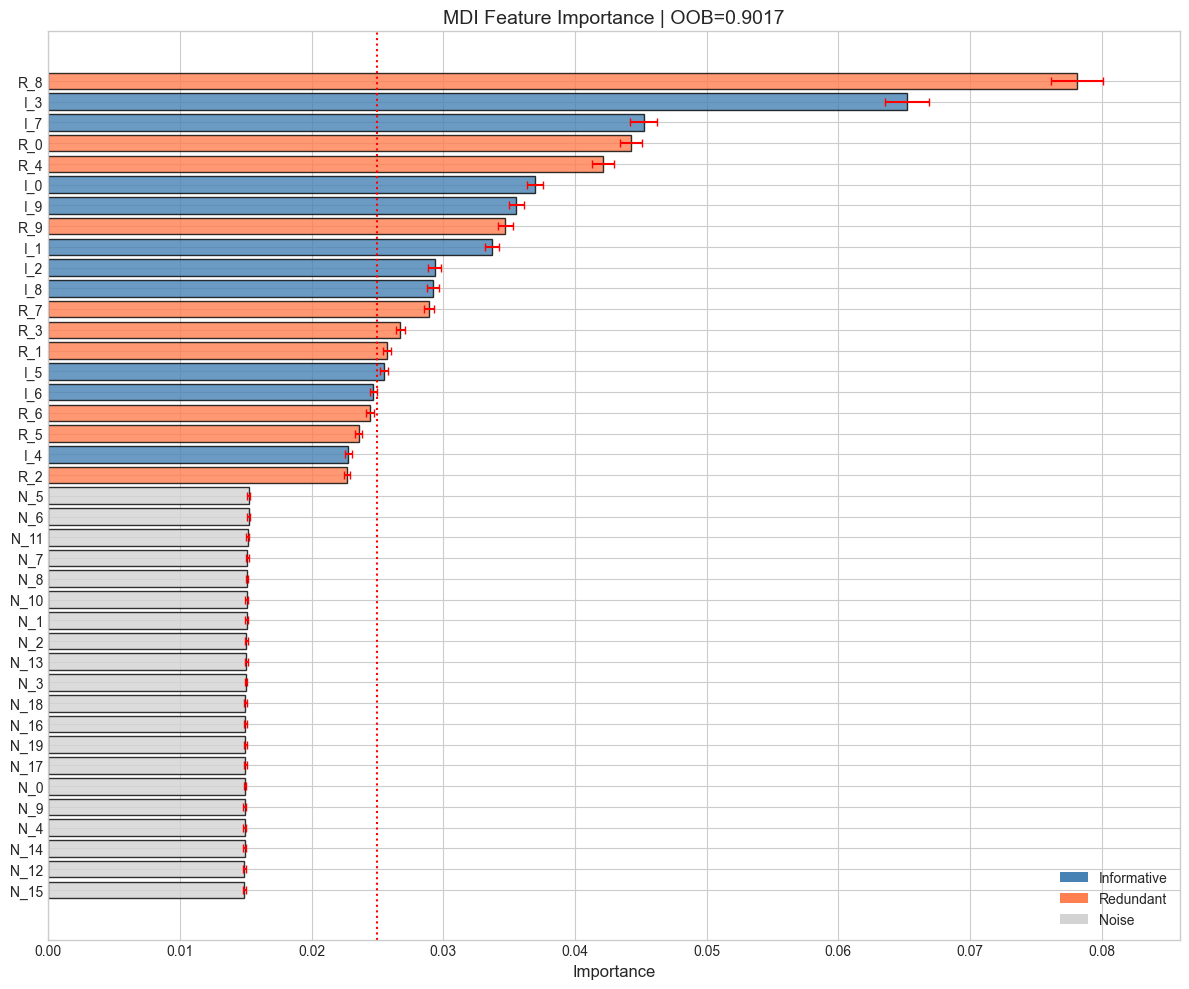


Interpretation:
- Blue bars = Informative features (should be high)
- Orange bars = Redundant features (should be high)
- Gray bars = Noise features (should be low)
- Red dotted line = Uniform importance (1/40 = 0.025)


In [6]:
# Visualize MDI importance
fig = plot_feature_importance(
    mdi_importance,
    method='MDI',
    oob_score=clf_mdi.oob_score_,
    color_by_type=True,
    figsize=(12, 10)
)
plt.show()

print("\nInterpretation:")
print("- Blue bars = Informative features (should be high)")
print("- Orange bars = Redundant features (should be high)")
print("- Gray bars = Noise features (should be low)")
print("- Red dotted line = Uniform importance (1/40 = 0.025)")

In [7]:
# Analyze MDI results by feature type
mdi_by_type = analyze_importance_by_type(mdi_importance, X.columns.tolist())

print("MDI Importance by Feature Type")
print("="*60)
print(mdi_by_type)
print()

# Compute detection accuracy
mdi_accuracy = compute_importance_accuracy(mdi_importance, X.columns.tolist())
print(f"Detection Performance:")
print(f"  Precision: {mdi_accuracy['precision']:.2%}")
print(f"  Recall: {mdi_accuracy['recall']:.2%}")
print(f"  F1 Score: {mdi_accuracy['f1_score']:.2%}")

MDI Importance by Feature Type
             count      mean       std       min       max       sum
type                                                                
Informative     10  0.034821  0.012621  0.022799  0.065215  0.348206
Noise           20  0.015025  0.000105  0.014887  0.015244  0.300499
Redundant       10  0.035129  0.016932  0.022709  0.078125  0.351295

Detection Performance:
  Precision: 100.00%
  Recall: 100.00%
  F1 Score: 100.00%


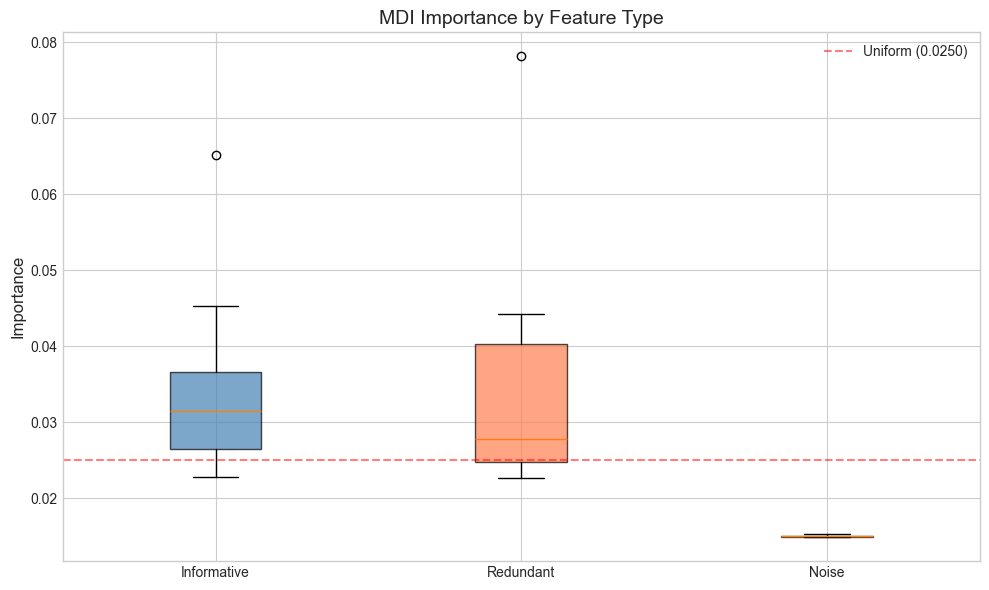

MDI successfully separates Informative/Redundant from Noise features!


In [8]:
# Box plot by feature type
fig = plot_importance_by_type(
    mdi_importance,
    X.columns.tolist(),
    method='MDI',
    figsize=(10, 6)
)
plt.show()

print("MDI successfully separates Informative/Redundant from Noise features!")

## 3. Mean Decrease Accuracy (MDA)

### How MDA Works

MDA (also called **Permutation Importance**) is a **slow, out-of-sample** method:

1. Fit a classifier and measure OOS performance (baseline)
2. For each feature:
   - **Randomly shuffle** (permute) that feature's values
   - Measure performance with the shuffled feature
   - Importance = (baseline - shuffled) / max_possible_improvement
3. Repeat across CV folds

### Key Considerations

| Advantage | Disadvantage |
|-----------|-------------|
| Works with any classifier | Slow (requires many model evaluations) |
| Out-of-sample (more reliable) | Subject to substitution effects |
| Can detect harmful features (negative importance) | Must use purged CV for financial data |

In [9]:
# For demonstration, use simple train/test split
# (In practice, use purged k-fold CV)
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42
)

# Train classifier
clf_mda = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
clf_mda.fit(X_train, y_train)

# Baseline accuracy
baseline_acc = clf_mda.score(X_test, y_test)
print(f"Baseline accuracy: {baseline_acc:.4f}")

Baseline accuracy: 0.8855


In [10]:
# Compute MDA importance
mda_importance = compute_mda_importance_simple(
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    X_train, y_train, X_test, y_test,
    feature_names=X.columns.tolist(),
    scoring='accuracy',
    n_repeats=10,
)

print("MDA Feature Importance (Top 15)")
print("="*50)
print(mda_importance.sort_values('mean', ascending=False).head(15))

MDA Feature Importance (Top 15)
        mean       std
R_8  0.06965  0.005814
R_0  0.02650  0.003017
I_0  0.02110  0.002827
I_3  0.01880  0.004925
R_4  0.01640  0.002508
I_9  0.01575  0.001764
R_9  0.01565  0.001975
R_5  0.01235  0.002560
I_1  0.01000  0.002269
I_7  0.00915  0.003592
R_7  0.00880  0.001005
I_4  0.00700  0.001718
I_5  0.00660  0.001530
I_2  0.00615  0.001141
R_6  0.00585  0.001718


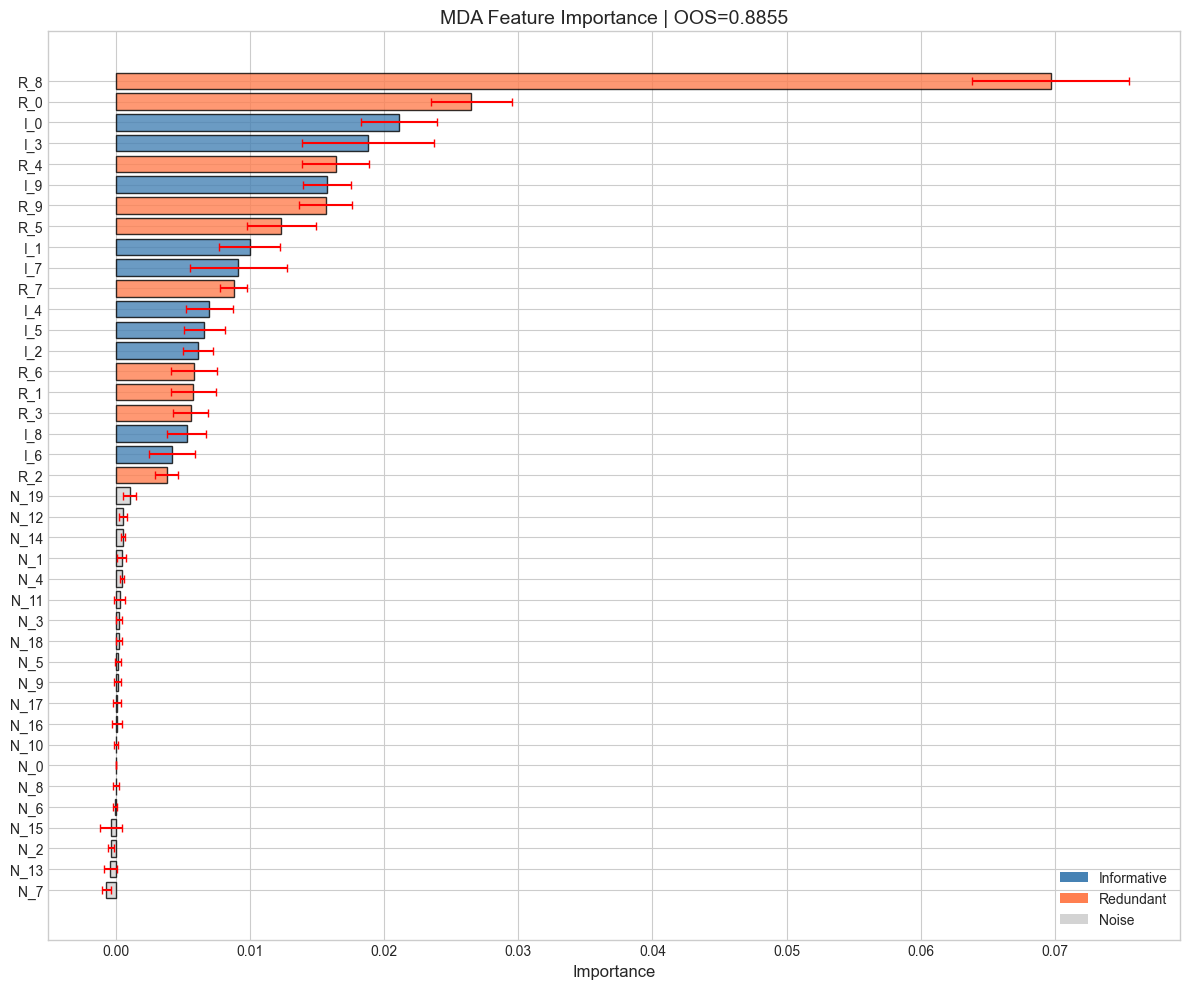

In [11]:
# Visualize MDA importance
fig = plot_feature_importance(
    mda_importance,
    method='MDA',
    oos_score=baseline_acc,
    color_by_type=True,
    figsize=(12, 10)
)
plt.show()

In [12]:
# Analyze MDA by feature type
mda_by_type = analyze_importance_by_type(mda_importance, X.columns.tolist())

print("MDA Importance by Feature Type")
print("="*60)
print(mda_by_type)
print()

# Compute detection accuracy
mda_accuracy = compute_importance_accuracy(mda_importance, X.columns.tolist())
print(f"Detection Performance:")
print(f"  Precision: {mda_accuracy['precision']:.2%}")
print(f"  Recall: {mda_accuracy['recall']:.2%}")
print(f"  F1 Score: {mda_accuracy['f1_score']:.2%}")

MDA Importance by Feature Type
             count      mean       std     min      max      sum
type                                                            
Informative     10  0.010405  0.005999  0.0042  0.02110  0.10405
Noise           20  0.000130  0.000396 -0.0007  0.00105  0.00260
Redundant       10  0.017040  0.019741  0.0038  0.06965  0.17040

Detection Performance:
  Precision: 100.00%
  Recall: 100.00%
  F1 Score: 100.00%


## 4. Single Feature Importance (SFI)

### How SFI Works

SFI is an **out-of-sample** method that evaluates each feature **in isolation**:

1. For each feature:
   - Train a classifier using **only that feature**
   - Measure OOS performance via CV
2. Rank features by their individual predictive power

### Key Considerations

| Advantage | Disadvantage |
|-----------|-------------|
| **No substitution effects** | Misses joint/hierarchical effects |
| Works with any classifier | A+B together might be better than A alone + B alone |
| Can find all features unimportant | Slow (train classifier for each feature) |

In [13]:
# Compute SFI importance (using a subset for speed)
# In practice, use all features
from sklearn.model_selection import KFold

# Use a simple classifier for SFI
clf_sfi = DecisionTreeClassifier(max_depth=3, random_state=42)

# Compute SFI for first 20 features (for speed)
feature_subset = X.columns[:20].tolist()

sfi_results = pd.DataFrame(columns=['mean', 'std'])

print("Computing SFI for 20 features...")
for feat_name in feature_subset:
    X_single = X[[feat_name]].values
    
    # Simple k-fold CV
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, test_idx in cv.split(X_single):
        clf = DecisionTreeClassifier(max_depth=3, random_state=42)
        clf.fit(X_single[train_idx], y[train_idx])
        scores.append(clf.score(X_single[test_idx], y[test_idx]))
    
    sfi_results.loc[feat_name, 'mean'] = np.mean(scores)
    sfi_results.loc[feat_name, 'std'] = np.std(scores) / np.sqrt(len(scores))

print("\nSFI Feature Importance (Top 15)")
print("="*50)
print(sfi_results.sort_values('mean', ascending=False).head(15))

Computing SFI for 20 features...



SFI Feature Importance (Top 15)
       mean       std
R_8  0.7375  0.004812
I_3  0.7153    0.0029
I_7  0.6624  0.003272
R_0  0.6397  0.003549
I_0  0.6182  0.005149
I_9  0.6092  0.005581
R_9  0.6091  0.003923
R_4  0.6062  0.003738
I_2  0.5969  0.003173
I_1  0.5963  0.002838
R_6  0.5801  0.001431
R_1  0.5754  0.002762
I_8  0.5712  0.004549
R_3  0.5699  0.003525
R_7  0.5539  0.004767


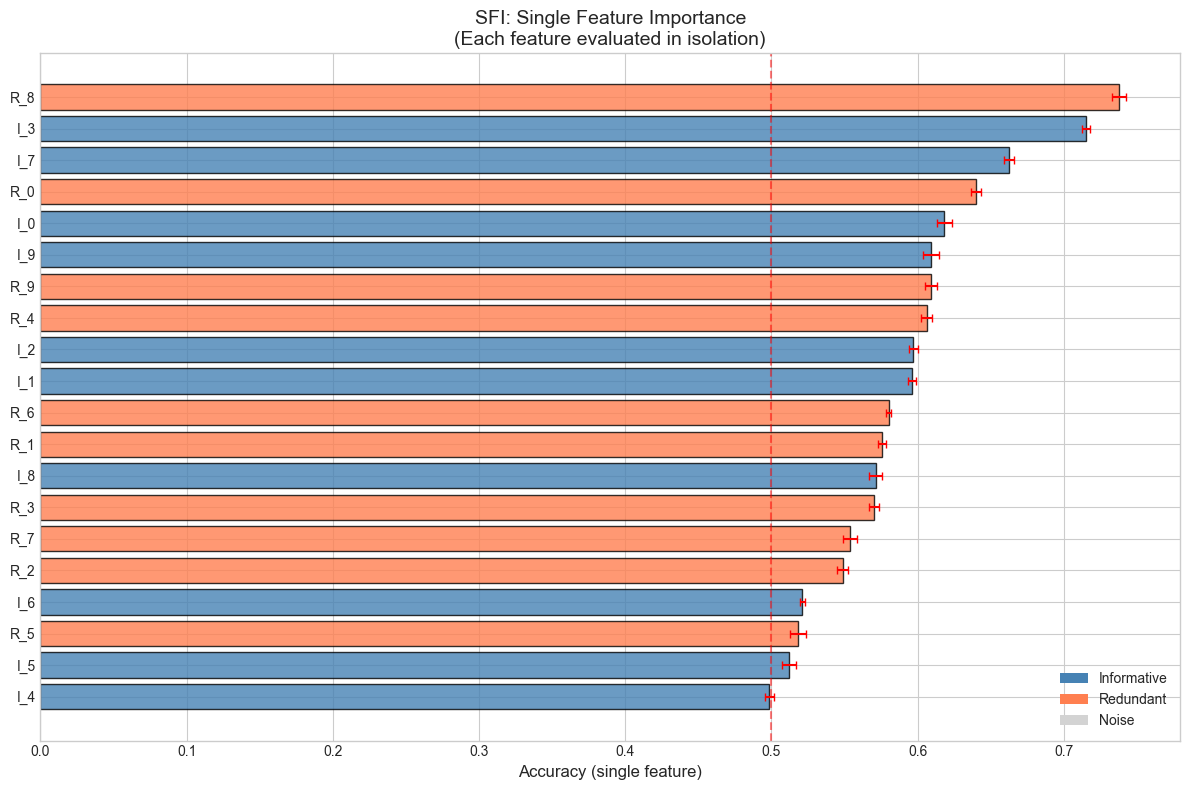


Note: SFI misses features that are only useful in combination with others.
Some informative features may appear unimportant when evaluated alone.


In [14]:
# Visualize SFI importance
fig, ax = plt.subplots(figsize=(12, 8))

sfi_sorted = sfi_results.sort_values('mean', ascending=True)

# Color by feature type
colors = []
for name in sfi_sorted.index:
    if name.startswith('I_'):
        colors.append('steelblue')
    elif name.startswith('R_'):
        colors.append('coral')
    else:
        colors.append('lightgray')

y_pos = np.arange(len(sfi_sorted))
ax.barh(y_pos, sfi_sorted['mean'], xerr=sfi_sorted['std'],
        color=colors, alpha=0.8, edgecolor='black',
        error_kw={'ecolor': 'red', 'capsize': 3})

# Reference line at 0.5 (random guess)
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Random guess (0.5)')

ax.set_yticks(y_pos)
ax.set_yticklabels(sfi_sorted.index)
ax.set_xlabel('Accuracy (single feature)', fontsize=12)
ax.set_title('SFI: Single Feature Importance\n(Each feature evaluated in isolation)', fontsize=14)
ax.legend()

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Informative'),
    Patch(facecolor='coral', label='Redundant'),
    Patch(facecolor='lightgray', label='Noise'),
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("\nNote: SFI misses features that are only useful in combination with others.")
print("Some informative features may appear unimportant when evaluated alone.")

## 5. Substitution Effects

### What Are Substitution Effects?

**Substitution effects** occur when correlated features "share" importance:

- If features A and B are identical, a tree can use either one
- The importance gets **split** between them
- Each appears less important than it truly is

This is the ML analogue of **multicollinearity** in statistics.

### Impact on Different Methods

| Method | Impact of Substitution Effects |
|--------|-------------------------------|
| **MDI** | Importance diluted among correlated features |
| **MDA** | Shuffling one feature leaves correlated features intact |
| **SFI** | **No impact** (each feature evaluated alone) |

In [15]:
# Demonstrate substitution effects
# Create a dataset where we duplicate an informative feature

print("Demonstrating Substitution Effects")
print("="*50)

# Generate simple data
n = 5000
np.random.seed(42)

# One truly informative feature
X_sub = pd.DataFrame()
X_sub['informative'] = np.random.randn(n)

# Create duplicates (perfect correlation)
X_sub['duplicate_1'] = X_sub['informative'].copy()
X_sub['duplicate_2'] = X_sub['informative'].copy()

# Add noise features
X_sub['noise_1'] = np.random.randn(n)
X_sub['noise_2'] = np.random.randn(n)

# Labels based on informative feature
y_sub = (X_sub['informative'] > 0).astype(int)

print(f"Dataset: {n} samples, 5 features")
print(f"  - 'informative': The true signal")
print(f"  - 'duplicate_1', 'duplicate_2': Copies of informative")
print(f"  - 'noise_1', 'noise_2': Random noise")
print(f"\nCorrelation matrix:")
print(X_sub.corr().round(3))

Demonstrating Substitution Effects
Dataset: 5000 samples, 5 features
  - 'informative': The true signal
  - 'duplicate_1', 'duplicate_2': Copies of informative
  - 'noise_1', 'noise_2': Random noise

Correlation matrix:
             informative  duplicate_1  duplicate_2  noise_1  noise_2
informative        1.000        1.000        1.000   -0.002   -0.003
duplicate_1        1.000        1.000        1.000   -0.002   -0.003
duplicate_2        1.000        1.000        1.000   -0.002   -0.003
noise_1           -0.002       -0.002       -0.002    1.000   -0.006
noise_2           -0.003       -0.003       -0.003   -0.006    1.000


In [16]:
# Train RF and compute MDI
clf_sub = RandomForestClassifier(
    n_estimators=500,
    max_features=1,
    random_state=42,
    n_jobs=-1
)
clf_sub.fit(X_sub.values, y_sub)

mdi_sub = compute_mdi_importance(clf_sub, X_sub.columns.tolist())

print("MDI with Substitution Effects")
print("="*50)
print(mdi_sub.sort_values('mean', ascending=False))
print()
print("Notice: The informative feature's importance is SPLIT among its duplicates!")
print(f"Total importance of informative + duplicates: {mdi_sub.loc[['informative', 'duplicate_1', 'duplicate_2'], 'mean'].sum():.4f}")

MDI with Substitution Effects
                 mean       std
duplicate_1  0.352075  0.016680
informative  0.333039  0.017730
duplicate_2  0.311204  0.019008
noise_2      0.001847  0.000124
noise_1      0.001835  0.000127

Notice: The informative feature's importance is SPLIT among its duplicates!
Total importance of informative + duplicates: 0.9963


/var/folders/hf/hwg72r856z362qcrv_4q2xp00000gn/T/ipykernel_68288/2773450954.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(expected.index, rotation=45, ha='right')
/var/folders/hf/hwg72r856z362qcrv_4q2xp00000gn/T/ipykernel_68288/2773450954.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(actual.index, rotation=45, ha='right')


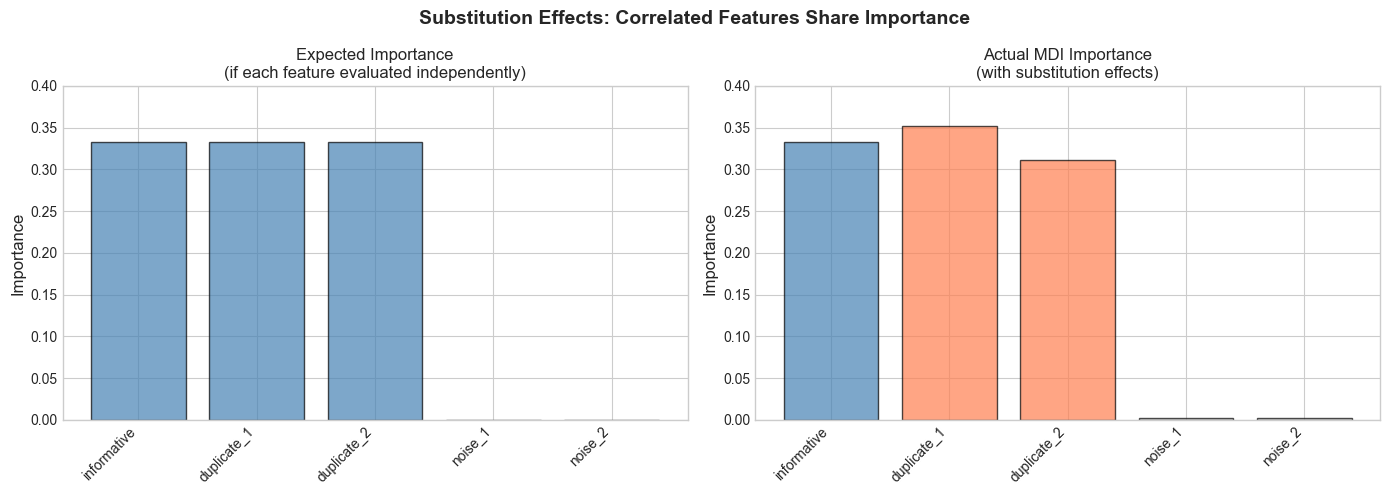

The duplicates 'steal' importance from the original informative feature.


In [17]:
# Visualize substitution effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Expected importance (if no substitution)
expected = pd.Series({
    'informative': 1.0,
    'duplicate_1': 1.0,  # Same as informative
    'duplicate_2': 1.0,  # Same as informative
    'noise_1': 0.0,
    'noise_2': 0.0,
})
expected = expected / expected.sum()  # Normalize

# Actual MDI
actual = mdi_sub['mean']

# Plot expected
ax1 = axes[0]
ax1.bar(expected.index, expected.values, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_ylabel('Importance', fontsize=12)
ax1.set_title('Expected Importance\n(if each feature evaluated independently)', fontsize=12)
ax1.set_xticklabels(expected.index, rotation=45, ha='right')
ax1.set_ylim(0, 0.4)

# Plot actual
ax2 = axes[1]
colors = ['steelblue', 'coral', 'coral', 'lightgray', 'lightgray']
ax2.bar(actual.index, actual.values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Importance', fontsize=12)
ax2.set_title('Actual MDI Importance\n(with substitution effects)', fontsize=12)
ax2.set_xticklabels(actual.index, rotation=45, ha='right')
ax2.set_ylim(0, 0.4)

plt.suptitle('Substitution Effects: Correlated Features Share Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("The duplicates 'steal' importance from the original informative feature.")

## 6. Orthogonal Features (PCA)

### Addressing Substitution Effects with PCA

**Principal Component Analysis (PCA)** can help address substitution effects:

1. Transform features to orthogonal (uncorrelated) space
2. Apply MDI/MDA on the orthogonal features
3. No more correlation = no more substitution effects

### Additional Benefit: Overfitting Detection

If PCA ranking (unsupervised) matches feature importance ranking (supervised), it suggests the pattern is **not entirely overfit**.

Why? PCA ranks features by variance explained **without seeing the labels**. If the ML algorithm finds the same features important **using the labels**, this is confirmatory evidence.

In [18]:
# Compute orthogonal features
ortho_X, eigenvalues, eigenvectors = compute_orthogonal_features(X, variance_threshold=0.95)

print("Orthogonal Features via PCA")
print("="*50)
print(f"Original features: {X.shape[1]}")
print(f"Orthogonal features (95% variance): {ortho_X.shape[1]}")
print(f"\nTop 5 eigenvalues:")
print(eigenvalues.head())
print(f"\nCumulative variance explained: {(eigenvalues.cumsum() / eigenvalues.sum()).iloc[-1]:.2%}")

Orthogonal Features via PCA
Original features: 40
Orthogonal features (95% variance): 27

Top 5 eigenvalues:
PC_1    48235.339253
PC_2    33885.148364
PC_3    28866.163924
PC_4    21459.509057
PC_5    17064.285023
dtype: float64

Cumulative variance explained: 100.00%


In [19]:
# Train RF on orthogonal features
clf_ortho = RandomForestClassifier(
    n_estimators=500,
    max_features=1,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)
clf_ortho.fit(ortho_X.values, y)

print(f"RF on orthogonal features - OOB Score: {clf_ortho.oob_score_:.4f}")

RF on orthogonal features - OOB Score: 0.8580


In [20]:
# Compute MDI on orthogonal features
mdi_ortho = compute_mdi_importance(clf_ortho, ortho_X.columns.tolist())

print("MDI on Orthogonal Features (Top 10)")
print("="*50)
print(mdi_ortho.sort_values('mean', ascending=False).head(10))

MDI on Orthogonal Features (Top 10)
           mean       std
PC_2   0.110276  0.002036
PC_3   0.103201  0.001750
PC_6   0.055915  0.000653
PC_1   0.048224  0.000655
PC_7   0.048062  0.000585
PC_5   0.043403  0.000414
PC_4   0.036752  0.000327
PC_15  0.028132  0.000207
PC_27  0.028071  0.000221
PC_16  0.028068  0.000215


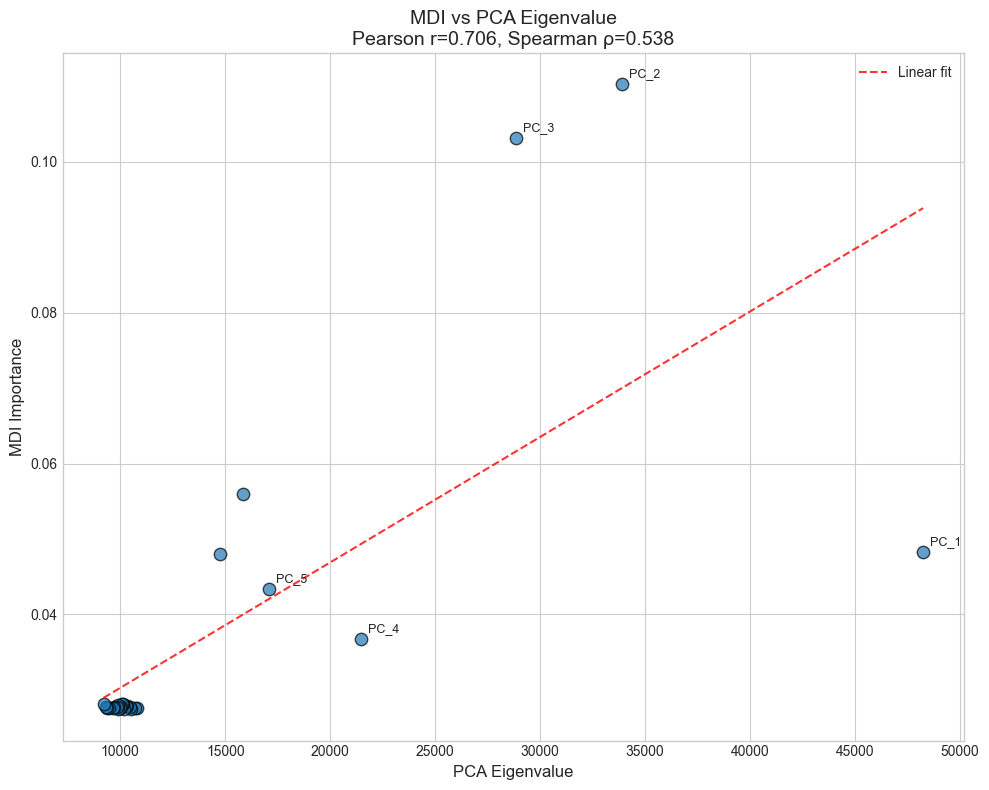


Interpretation:
High correlation between MDI and PCA ranking suggests the pattern is not overfit.
PCA found important directions WITHOUT seeing labels.
MDI found the same directions important USING labels.
This agreement is confirmatory evidence.


In [21]:
# Compare MDI with PCA eigenvalues
fig, ax = plt.subplots(figsize=(10, 8))

# Align data
common_pcs = mdi_ortho.index.intersection(eigenvalues.index)
mdi_values = mdi_ortho.loc[common_pcs, 'mean'].values
eig_values = eigenvalues.loc[common_pcs].values

ax.scatter(eig_values, mdi_values, s=80, alpha=0.7, edgecolors='black')

# Add labels for top points
for i, pc in enumerate(common_pcs[:5]):
    ax.annotate(pc, (eig_values[i], mdi_values[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Correlation line
z = np.polyfit(eig_values, mdi_values, 1)
p = np.poly1d(z)
x_line = np.linspace(eig_values.min(), eig_values.max(), 100)
ax.plot(x_line, p(x_line), 'r--', alpha=0.8, label='Linear fit')

# Compute correlations
from scipy.stats import pearsonr, spearmanr
pearson_r, _ = pearsonr(eig_values, mdi_values)
spearman_r, _ = spearmanr(eig_values, mdi_values)

ax.set_xlabel('PCA Eigenvalue', fontsize=12)
ax.set_ylabel('MDI Importance', fontsize=12)
ax.set_title(f'MDI vs PCA Eigenvalue\nPearson r={pearson_r:.3f}, Spearman ρ={spearman_r:.3f}', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("High correlation between MDI and PCA ranking suggests the pattern is not overfit.")
print("PCA found important directions WITHOUT seeing labels.")
print("MDI found the same directions important USING labels.")
print("This agreement is confirmatory evidence.")

In [22]:
# Compute weighted Kendall's tau
pca_rank = np.arange(1, len(common_pcs) + 1)  # PC_1 is rank 1, etc.

# Sort MDI by importance (descending) and get corresponding PCA ranks
mdi_sorted = mdi_ortho.loc[common_pcs].sort_values('mean', ascending=False)
pca_ranks_for_mdi = [int(pc.split('_')[1]) for pc in mdi_sorted.index]

tau, p_value = compute_weighted_kendall_tau(
    mdi_sorted['mean'].values,
    np.array(pca_ranks_for_mdi)
)

print(f"Weighted Kendall's tau: {tau:.4f}")
print(f"\nInterpretation:")
print(f"  tau ≈ 1: Perfect agreement between MDI and PCA ranking")
print(f"  tau ≈ 0: No relationship")
print(f"  tau ≈ -1: Perfect disagreement")
print(f"\nOur tau = {tau:.4f} suggests {'strong' if tau > 0.6 else 'moderate' if tau > 0.3 else 'weak'} agreement.")

Weighted Kendall's tau: 0.6321

Interpretation:
  tau ≈ 1: Perfect agreement between MDI and PCA ranking
  tau ≈ 0: No relationship
  tau ≈ -1: Perfect disagreement

Our tau = 0.6321 suggests strong agreement.


## 7. Comparing Methods

Let's compare all three methods side by side on our synthetic data.

In [23]:
# Create comparison DataFrame
comparison = pd.DataFrame(index=X.columns)
comparison['MDI'] = mdi_importance['mean']
comparison['MDA'] = mda_importance['mean']

# Add feature type
comparison['type'] = get_feature_types(X.columns.tolist())

print("Method Comparison (Top 15 by MDI)")
print("="*60)
print(comparison.sort_values('MDI', ascending=False).head(15))

Method Comparison (Top 15 by MDI)
          MDI      MDA type
R_8  0.078125  0.06965    R
I_3  0.065215  0.01880    I
I_7  0.045236  0.00915    I
R_0  0.044268  0.02650    R
R_4  0.042100  0.01640    R
I_0  0.036943  0.02110    I
I_9  0.035550  0.01575    I
R_9  0.034704  0.01565    R
I_1  0.033691  0.01000    I
I_2  0.029348  0.00615    I
I_8  0.029214  0.00530    I
R_7  0.028897  0.00880    R
R_3  0.026742  0.00560    R
R_1  0.025726  0.00580    R
I_5  0.025510  0.00660    I


In [24]:
# Correlation between methods
method_corr = comparison[['MDI', 'MDA']].corr()

print("Correlation Between Methods")
print("="*40)
print(method_corr)

Correlation Between Methods
          MDI       MDA
MDI  1.000000  0.890629
MDA  0.890629  1.000000


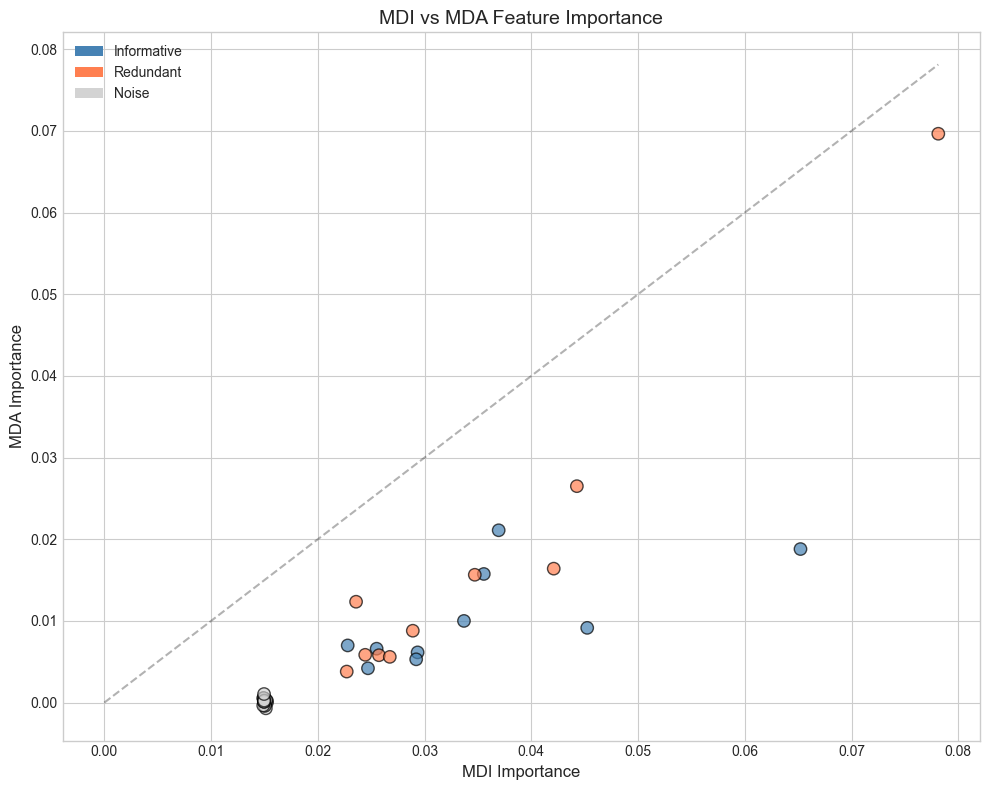

MDI and MDA generally agree on which features are important.


In [25]:
# Scatter plot: MDI vs MDA
fig, ax = plt.subplots(figsize=(10, 8))

# Color by feature type
colors = comparison['type'].map({'I': 'steelblue', 'R': 'coral', 'N': 'lightgray'})

ax.scatter(comparison['MDI'], comparison['MDA'], c=colors, s=80, alpha=0.7, edgecolors='black')

# Add diagonal line
max_val = max(comparison['MDI'].max(), comparison['MDA'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='y=x')

ax.set_xlabel('MDI Importance', fontsize=12)
ax.set_ylabel('MDA Importance', fontsize=12)
ax.set_title('MDI vs MDA Feature Importance', fontsize=14)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Informative'),
    Patch(facecolor='coral', label='Redundant'),
    Patch(facecolor='lightgray', label='Noise'),
]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

print("MDI and MDA generally agree on which features are important.")

In [26]:
# Summary by feature type and method
summary = comparison.groupby('type').agg({
    'MDI': ['mean', 'std'],
    'MDA': ['mean', 'std'],
})

# Rename index
summary.index = summary.index.map({'I': 'Informative', 'R': 'Redundant', 'N': 'Noise'})

print("Summary by Feature Type")
print("="*60)
print(summary)
print()
print("Both MDI and MDA correctly identify Informative and Redundant features")
print("as more important than Noise features.")

Summary by Feature Type
                  MDI                 MDA          
                 mean       std      mean       std
type                                               
Informative  0.034821  0.012621  0.010405  0.005999
Noise        0.015025  0.000105  0.000130  0.000396
Redundant    0.035129  0.016932  0.017040  0.019741

Both MDI and MDA correctly identify Informative and Redundant features
as more important than Noise features.


## 8. Best Practices

### Summary of Feature Importance Methods

| Method | Type | Speed | Substitution Effects | Best For |
|--------|------|-------|---------------------|----------|
| **MDI** | In-sample | Fast | Yes | Quick analysis, tree-based models |
| **MDA** | Out-of-sample | Slow | Yes | Any classifier, production use |
| **SFI** | Out-of-sample | Slow | No | Understanding individual features |

### Recommendations

1. **Use multiple methods**: MDI, MDA, and SFI complement each other
2. **Set `max_features=1`** for MDI to avoid masking effects
3. **Use purged CV** for MDA and SFI with financial data
4. **Apply PCA** to address linear substitution effects
5. **Compare PCA ranking with importance ranking** to detect overfitting
6. **Do feature importance BEFORE backtesting** - it's a research tool!

### Warning Signs

- Features with high MDI but low MDA/SFI → might be overfitting
- All features equally important → model might not be learning
- Noise features ranking high → data leakage or overfitting
- PCA ranking doesn't match importance → possible overfit

In [27]:
# Final summary
print("Feature Importance Tutorial Complete!")
print("="*60)
print("\nKey Takeaways:")
print()
print("1. MARCOS' FIRST LAW: Feature importance is a research tool,")
print("   backtesting is not. Do feature importance FIRST.")
print()
print("2. THREE METHODS:")
print("   - MDI: Fast, in-sample, use max_features=1")
print("   - MDA: Slow, out-of-sample, works with any classifier")
print("   - SFI: No substitution effects, but misses joint effects")
print()
print("3. SUBSTITUTION EFFECTS:")
print("   - Correlated features share importance")
print("   - Use PCA to orthogonalize features")
print()
print("4. OVERFITTING DETECTION:")
print("   - Compare PCA ranking with importance ranking")
print("   - High correlation = confirmatory evidence")
print()
print("Functions available in afml.feature_importance:")
print("  - compute_mdi_importance()")
print("  - compute_mda_importance()")
print("  - compute_sfi_importance()")
print("  - compute_orthogonal_features()")
print("  - compute_weighted_kendall_tau()")
print("  - generate_synthetic_dataset()")
print("  - plot_feature_importance()")

Feature Importance Tutorial Complete!

Key Takeaways:

1. MARCOS' FIRST LAW: Feature importance is a research tool,
   backtesting is not. Do feature importance FIRST.

2. THREE METHODS:
   - MDI: Fast, in-sample, use max_features=1
   - MDA: Slow, out-of-sample, works with any classifier
   - SFI: No substitution effects, but misses joint effects

3. SUBSTITUTION EFFECTS:
   - Correlated features share importance
   - Use PCA to orthogonalize features

4. OVERFITTING DETECTION:
   - Compare PCA ranking with importance ranking
   - High correlation = confirmatory evidence

Functions available in afml.feature_importance:
  - compute_mdi_importance()
  - compute_mda_importance()
  - compute_sfi_importance()
  - compute_orthogonal_features()
  - compute_weighted_kendall_tau()
  - generate_synthetic_dataset()
  - plot_feature_importance()
